In [1]:
import pandas as pd
import string
import numpy as np
import textstat as txst
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import nltk
from nltk.corpus import stopwords

train_df = pd.read_csv('data/train.csv', encoding = 'latin-1')

train_df['rd_flesch_ease'] = train_df.excerpt.apply(txst.flesch_reading_ease)
train_df['rd_dalechall'] = train_df.excerpt.apply(txst.dale_chall_readability_score)
train_df['rd_colemanliau'] = train_df.excerpt.apply(txst.coleman_liau_index)

# Cleaning
train_df['excerpt'] = train_df['excerpt'].str.lower()#Remove punctuation
table = str.maketrans('', '', string.punctuation)
train_df['excerpt'] = [train_df['excerpt'][row].translate(table) for row in range(len(train_df['excerpt']))]#Remove stopwords

nltk.download('stopwords')

stop = stopwords.words('english')
train_df['excerpt'] = train_df['excerpt'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


[nltk_data] Downloading package stopwords to /home/edu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(norm="l2")
processed_text = vectorizer.fit_transform(train_df['excerpt']).toarray()

train_df['processed_text'] = [sum(arr) for arr in processed_text]

In [3]:
# Remove the targets from the set
# Convert pandas df to np arrays
feature_list = ['processed_text', 'standard_error', 'rd_flesch_ease', 'rd_dalechall', 'rd_colemanliau']
features = np.array(train_df[feature_list])
targets = np.array(train_df['target'])
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=20)
#### NOTE! I'm setting random_state to 20 so we get the same results every time we run the split.
#### Results are reproducible, but maybe this is not the best approach

In [4]:
# Sanity check: we expect the training features number of columns to match the testing feature number of columns 
# and the number of rows to match for the respective training and testing features and the labels
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (2267, 5)
Training Labels Shape: (2267,)
Testing Features Shape: (567, 5)
Testing Labels Shape: (567,)


In [5]:
# We establish baseline: We want our model to beat the mean of the standard error.
baseline_errors = train_df['standard_error']
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.49


In [6]:
# Instantiate model with 1000 decision trees
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 20)
#### NOTE! random_state again

# Train the model on training data
rf.fit(X_train, y_train)

pred = rf.predict(X_test)

In [7]:
# Compute performance
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error (MAE): 0.5573044284159364
Mean Squared Error (MSE): 0.5731842847371093
Root Mean Squared Error (RMSE): 0.7570893505637952


In [8]:
### MODEL ANALYSIS

# Get numerical feature relevance
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True) 
for pair in feature_importances:
    print('Variable: {:20}{}'.format(*pair))


Variable: rd_dalechall        0.42
Variable: standard_error      0.3
Variable: processed_text      0.12
Variable: rd_flesch_ease      0.08
Variable: rd_colemanliau      0.08


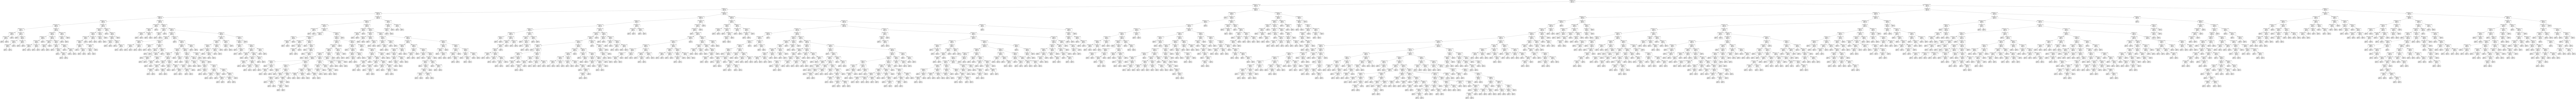

In [9]:
# Visualization of a single tree
from sklearn.tree import export_graphviz
import pydot
from IPython.core.display import Image, display

tree = rf.estimators_[10]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
display(Image('tree.png', height=1700, width=29000, unconfined=True))